In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder  

In [2]:
try:
    df = pd.read_json('problems_data.jsonl', lines=True)
except ValueError:
    print("Error: check filetype again")
    exit()

In [ ]:
#Data preprocessing
df = df.dropna(subset=['problem_score', 'problem_class'])
le = LabelEncoder()
df['difficulty_label'] = le.fit_transform(df['problem_class'])
class_mapping = {k: int(v) for k, v in zip(le.classes_, le.transform(le.classes_))} #int(v) so int64 doesn't come
print("Mapping:", class_mapping) #yo remember hard is 1
text_columns = ['title', 'description', 'input_description', 'output_description']
for col in text_columns:
    df[col] = df[col].fillna('')

df['combined_text'] = (
    df['title'] + " " + 
    df['description'] + " " + 
    df['input_description'] + " " + 
    df['output_description']
)

def upd(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = " ".join(text.split())
    return text

df['combined_text'] = df['combined_text'].apply(upd)

Mapping: {'easy': 0, 'hard': 1, 'medium': 2}


In [ ]:
#feature extraction
hard_topics = [
    'convex hull', 'mobius', 'segment tree', 'flow', 'centroid', 
    'geometry', 'gcd', 'mex', 'dynamic programming', 
    'modulo', 'bitwise', 'graph', 'expected value','permutations','xor','shortest path','grid','query','range','range query'
]
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    col_name = f'has_{topic.replace(" ", "_")}'
    df[col_name] = df['combined_text'].str.contains(topic, case=False).astype(int)  

df['hard_topic_count'] = 0
for j in range(len(hard_topics)):
    topic = hard_topics[j]
    df['hard_topic_count'] += df['combined_text'].str.contains(topic, case=False).astype(int)
    
                                                                            
df['is_short_statement'] = (df['combined_text'].str.len() < 300).astype(int)
df['text_len'] = df['combined_text'].apply(len)
mathsym = ['$', '^', '{', '}', '_', '\\', '=', '<', '>','*']
df['math_count'] = 0
for j in range(len(mathsym)):
    sym = mathsym[j]
    df['math_count'] += df['combined_text'].str.count(re.escape(sym))
df['has_high_constraints'] = df['combined_text'].str.contains(r'10\^5|10\^9|1000000007|1e9|1e5', regex=True).astype(int)
df['math_density'] = df['math_count'] / (df['combined_text'].str.len() + 1)

In [ ]:
#feature extraction pt2
import pandas as pd
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

def probfind(df):
    classes = [0, 1, 2] 
    class_data = {}
    
    for cls in classes:
        subset = df[df['difficulty_label'].isin([cls, str(cls)])]['combined_text'].dropna()
        
        if len(subset) == 0:
            print(f"debug, some data missing for this {cls}. Skipping...")
            class_data[str(cls)] = {}
            continue
            
        vec = CountVectorizer(binary=True, token_pattern=r"(?u)\b\w+\b")
        try:
            matrix = vec.fit_transform(subset)
            probs = matrix.sum(axis=0).A1 / len(subset)
            class_data[str(cls)] = dict(zip(vec.get_feature_names_out(), probs))
        except ValueError:
            class_data[str(cls)] = {}
            
    return class_data

probs = probfind(df)
all_words = set(probs['0'].keys()) | set(probs['1'].keys()) | set(probs['2'].keys())
feature_scores = []

for word in all_words:
    p0 = probs['0'].get(word, 0)
    p1 = probs['1'].get(word, 0) 
    p2 = probs['2'].get(word, 0) 
    
    spread = max(p0, p1, p2) - min(p0, p1, p2)
    is_noise = (p0 > 0.25 and p1 > 0.25 and p2 > 0.25)
    feature_scores.append({'word': word, 'spread': spread, 'is_noise': is_noise})

features_df = pd.DataFrame(feature_scores)
new_cp_stopwords = features_df[features_df['is_noise'] == True]['word'].tolist()
# print(new_cp_stopwords)
cp_manual_stop = [
    'input', 'output', 'line', 'number', 'integer', 'integers', 
    'problem', 'given', 'contains', 'possible', 'single', 'test', 
    'case', 'cases', 'print', 'outputting', 'standard', 'format', 'program', 'write', 'le', 'leq', 'consists', 'help',
    'containing', 'contain', 'time', 'giving', 'following', 'exactly','completely','satisfy','loves','love',
]

merged_stopwords = list(set(cp_manual_stop).union(set(new_cp_stopwords)))
final_stopwords = list(text.ENGLISH_STOP_WORDS.union(merged_stopwords))

# print(final_stopwords)
# print("shit")
tfidf = TfidfVectorizer(
    max_features=3000, 
    stop_words=final_stopwords, 
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(df['combined_text'])
hard_dist = probs['1']
med_dist = probs['2']
easy_dist = probs['0']
mediumvec = []
hardvec = []
for word, prob in hard_dist.items():
    if word in final_stopwords:
        continue
    p_m = med_dist.get(word, 0)
    p_e = easy_dist.get(word, 0)
    if prob > 2*p_m:
        hardvec.append((word, prob))

for word, prob in med_dist.items():
    if word in final_stopwords:
        continue
    p_h = hard_dist.get(word, 0)
    p_e = easy_dist.get(word, 0)
    if prob > 2*p_h:
        mediumvec.append((word, prob))
# print(len(hardvec))
hardvec.sort(key=lambda x: x[1], reverse=True)
# print("Top 15 Hard-Only Signals:")
# for word, prob in hardvec[:15]:
#     print(f"{word}: {prob:.4f}")
hard_keywords = [word for word, prob in hardvec[:30]] # Take the top 30?
mediumvec.sort(key=lambda x: x[1], reverse=True)
medium_keywords = [word for word, prob in mediumvec[:30]]

df['high_difficulty_signal_count'] = df['combined_text'].apply(
    lambda x: sum(1 for word in hard_keywords if word in x.lower())
)
df['medium_signal_count'] = df['combined_text'].apply(
    lambda x: sum(1 for word in medium_keywords if word in x.lower())
)
X_manual = df[['hard_topic_count', 'math_density', 'text_len', 'high_difficulty_signal_count','is_short_statement','has_high_constraints','medium_signal_count']].values
X_manual[:, -1] *= 5 
Xf = sp.hstack((X_tfidf, X_manual))
#XF is final feature matrix
print("Feature Matrix Shape:", Xf.shape)


Feature Matrix Shape: (4112, 3007)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_trainc, y_testc = train_test_split(
    Xf, 
    df['difficulty_label'], 
    test_size=0.3, 
    random_state=7,   #rerun doesn't changes it
    stratify=df['difficulty_label']  #maintain a good ratio
)
# how the hell rerun changed it bruh
print(f" on {X_train.shape[0]} problems...")

 on 2878 problems...


In [ ]:
#tried Grid Search CV with pipeline and svd, went out with manual one since it was giving better results
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD

pipe = Pipeline([
    ('svd', TruncatedSVD(n_components=700, random_state=7)),
    ('clf', RandomForestClassifier(oob_score=True, random_state=7))
])

param_grid = {
    'svd__n_components': [100, 200],
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['sqrt', 0.2],
    'clf__max_depth': [None, 30],
    'clf__min_samples_leaf': [1, 3],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=2)
gs.fit(X_train, y_trainc)
print("Best params:", gs.best_params_)
print("CV score:", gs.best_score_)
best = gs.best_estimator_
y_predc = best.predict(X_test)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   2.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   2.7s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   2.7s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.8s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   4.0s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf

Out of Bag Score: 0.5045

Test Accuracy: 0.4968

Model Accuracy: 0.50

              precision    recall  f1-score   support

        easy       0.47      0.15      0.23       230
        hard       0.53      0.82      0.65       582
      medium       0.38      0.23      0.29       422

    accuracy                           0.50      1234
   macro avg       0.46      0.40      0.39      1234
weighted avg       0.47      0.50      0.45      1234



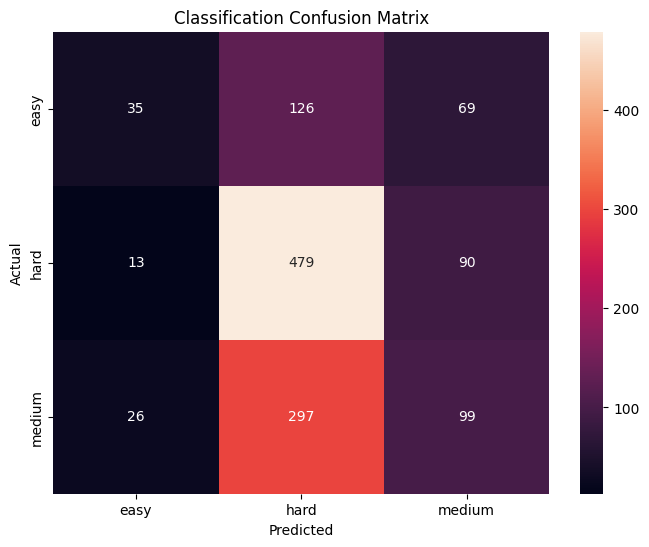

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

try:
    model_used = best
    y_predc = best.predict(X_test)
except NameError:
    model_used = RandomForestClassifier(
        n_estimators=300,
        max_features='sqrt',
        class_weight='balanced_subsample',
        min_samples_leaf=3,
        oob_score=True,
        random_state=7,
    )
    model_used.fit(X_train, y_trainc)
    y_predc = model_used.predict(X_test)

oob = None
try:
    oob = model_used.oob_score_
except Exception:
    try:
        oob = model_used.named_steps['clf'].oob_score_
    except Exception:
        oob = None

if oob is not None:
    print(f"Out of Bag Score: {oob:.4f}")
    print()

print(f"Test Accuracy: {model_used.score(X_test, y_testc):.4f}")
print()
print(f"Model Accuracy: {accuracy_score(y_testc, y_predc):.2f}")
print()
print(classification_report(y_testc, y_predc, target_names=le.classes_))

cm = confusion_matrix(y_testc, y_predc)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Confusion Matrix')
plt.show()

In [ ]:
svd_model = best.named_steps['svd']
vocab = tfidf.get_feature_names_out() 
#Looking at top words in each SVD component
for i, comp in enumerate(svd_model.components_[:20]):
    word_weights = zip(vocab, comp)
    sorted_words = sorted(word_weights, key=lambda x: x[1], reverse=True)[:10]
    
    print(f"Top words in SVD Component {i}:")
    print([word for word, weight in sorted_words])
    print("-" * 30)

Top words in SVD Component 0:
['numbers', 'string', 'game', 'sequence', 'player', 'th', 'points', '100', 'value', 'point']
------------------------------
Top words in SVD Component 1:
['dice', 'winner', 'digits', 'divisible', 'player', 'zeros', 'matches', '31', 'page', 'numbers']
------------------------------
Top words in SVD Component 2:
['polygon', 'vertices', 's_', 'y_', 'maximum', 'v_', 's_1', 'x_ y_', 'graph', 'x_']
------------------------------
Top words in SVD Component 3:
['grid', 'graph', 'modulo', 'range', 'nodes', 'edges', 'query', 'cells', 'queries', 'cell']
------------------------------
Top words in SVD Component 4:
['cdot', 'a_', 'modulo', 'th', 'x_', 'string', 's_', 'subsequence', 'length', 'nodes']
------------------------------
Top words in SVD Component 5:
['numbers', 'divisors', 'sum', 'positive', 'prime', 'divisor', 'digits', 'letter', 'letters', 'compute']
------------------------------
Top words in SVD Component 6:
['string', 'word', 'letters', 'words', 'letter

Out of Bag Score: 0.5049


Test Accuracy: 0.5259


Model Accuracy: 0.53


              precision    recall  f1-score   support

        easy       0.47      0.35      0.40       230
        hard       0.58      0.74      0.65       582
      medium       0.44      0.33      0.38       422

    accuracy                           0.53      1234
   macro avg       0.49      0.47      0.47      1234
weighted avg       0.51      0.53      0.51      1234



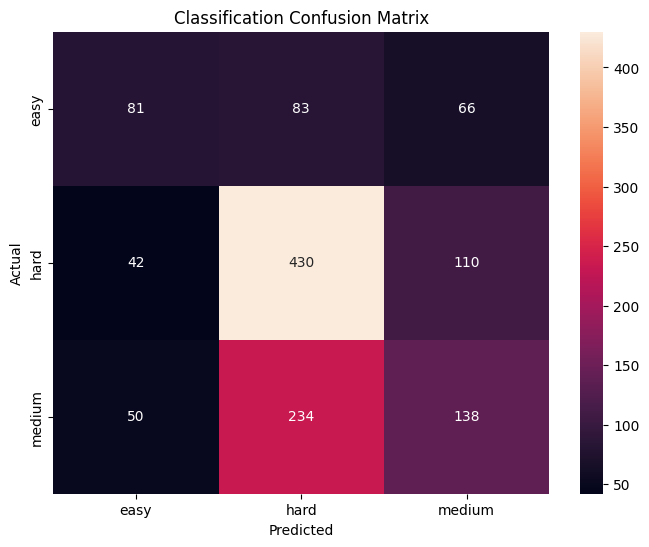

In [26]:
#classification model final code
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=500, 
    max_features=0.2, 
    class_weight='balanced_subsample', 
    min_samples_leaf=1,              
    oob_score=True,
    random_state=7,
)
clf.fit(X_train, y_trainc)
y_predc2 = clf.predict(X_test)
print(f"Out of Bag Score: {clf.oob_score_:.4f}")
print("\n")
print(f"Test Accuracy: {clf.score(X_test, y_testc):.4f}")
print("\n")
print(f"Model Accuracy: {accuracy_score(y_testc, y_predc2):.2f}")
print("\n")
print(classification_report(y_testc, y_predc2, target_names=le.classes_))
cm = confusion_matrix(y_testc, y_predc2)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Confusion Matrix')
plt.show()


In [ ]:
#looking at feature importances which features the model actually used
importances = clf.feature_importances_
feature_names = list(tfidf.get_feature_names_out()) + ['hard_topic_count', 'math_density', 'text_len', 'high_difficulty_signal_count','is_short_statement','has_high_constraints','medium_signal_count']
importance_dict = dict(zip(feature_names, importances))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
print("TOP 10 FEATURES THE MODEL ACTUALLY USED:")
for name, val in sorted_importance[:10]:
    print(f"{name}: {val:.4f}")
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)
print("TOP 10 FEATURES THE MODEL ACTUALLY NEVER USED:")
for name, val in sorted_importance[:10]:
    print(f"{name}: {val:.4f}")

TOP 10 FEATURES THE MODEL ACTUALLY USED:
text_len: 0.0442
high_difficulty_signal_count: 0.0220
math_density: 0.0215
hard_topic_count: 0.0090
medium_signal_count: 0.0075
100: 0.0071
minimum: 0.0069
characters: 0.0064
different: 0.0050
separated: 0.0049
TOP 10 FEATURES THE MODEL ACTUALLY NEVER USED:
alf: 0.0000
bullet: 0.0000
flubber: 0.0000
gl: 0.0000
gl bot: 0.0000
gym: 0.0000
monkey: 0.0000
nucleotide: 0.0000
pete: 0.0000
potatoes: 0.0000


In [ ]:
from joblib import dump, load
import os
os.makedirs('models', exist_ok=True)
model_to_save = clf
dump(model_to_save, 'models/model_best.joblib', compress=3)
dump(tfidf, 'models/tfidf.joblib', compress=3)
dump(le, 'models/label_encoder.joblib', compress=3)
import pickle
with open('models/model_best.pkl', 'wb') as f:
    pickle.dump(model_to_save, f)
with open('models/tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
model = load('models/model_best.joblib')        
with open('models/model_best.pkl', 'rb') as f:
    model = pickle.load(f)

-----------------Regression starts from here-----------------------------------------------

In [ ]:
#tried Grid Search CV with pipeline and svd, didnt use this as final model again because other models were giving better metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
df['problem_score_100'] = df['problem_score'].astype(float) * 10.0
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    Xf,
    df['problem_score_100'].astype(float),
    test_size=0.3,
    random_state=7,
)
print(f" on {X_train_reg.shape[0]} problems...")
pipe = Pipeline([
    ('svd', TruncatedSVD(n_components=400, random_state=7)),
    ('clf', RandomForestRegressor(oob_score=True, random_state=7))
])
param_grid = {
    'svd__n_components': [100, 200],
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['sqrt', 0.2],
    'clf__max_depth': [None, 30],
    'clf__min_samples_leaf': [1, 3],
}
cv = KFold(n_splits=3, shuffle=True, random_state=7)
gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
gs.fit(X_train_reg, y_train_reg)
print("Best params:", gs.best_params_)
print("CV neg MSE:", gs.best_score_)
print("R2 Score on Test Set:", r2_score(y_test_reg, gs.best_estimator_.predict(X_test_reg)))
best = gs.best_estimator_
y_pred_reg = best.predict(X_test_reg)

 on 2878 problems...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   2.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   2.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=100; total time=   2.5s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.2s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.3s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__n_estimators=200, svd__n_components=200; total time=   3.4s
[CV] END clf__max_depth=None, clf__max_features=sqrt, 

In [15]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
print("MSE:", mse, "RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("R2:", r2_score(y_test_reg, y_pred_reg))
baseline = np.full_like(y_test_reg, np.mean(y_train_reg))
print("Baseline MSE:", mean_squared_error(y_test_reg, baseline))


MSE: 402.02254041327257 RMSE: 20.050499754701193
MAE: 16.99003453720978
R2: 0.1309703162508199
Baseline MSE: 462.6846975395255


Training until validation scores don't improve for 3000 rounds
[200]	train's rmse: 0.427808	valid's rmse: 0.448009
[400]	train's rmse: 0.405724	valid's rmse: 0.443364
[600]	train's rmse: 0.391428	valid's rmse: 0.441744
[800]	train's rmse: 0.381026	valid's rmse: 0.441158
[1000]	train's rmse: 0.372903	valid's rmse: 0.441417
[1200]	train's rmse: 0.36583	valid's rmse: 0.441888
[1400]	train's rmse: 0.359345	valid's rmse: 0.44237
[1600]	train's rmse: 0.353239	valid's rmse: 0.443064
[1800]	train's rmse: 0.347718	valid's rmse: 0.443541
[2000]	train's rmse: 0.342185	valid's rmse: 0.44394
[2200]	train's rmse: 0.336911	valid's rmse: 0.444431
[2400]	train's rmse: 0.332039	valid's rmse: 0.444645
[2600]	train's rmse: 0.32741	valid's rmse: 0.444928
[2800]	train's rmse: 0.322914	valid's rmse: 0.445114
[3000]	train's rmse: 0.318895	valid's rmse: 0.445401
[3200]	train's rmse: 0.315925	valid's rmse: 0.445668
[3400]	train's rmse: 0.313728	valid's rmse: 0.445913
[3600]	train's rmse: 0.311951	valid's rmse: 

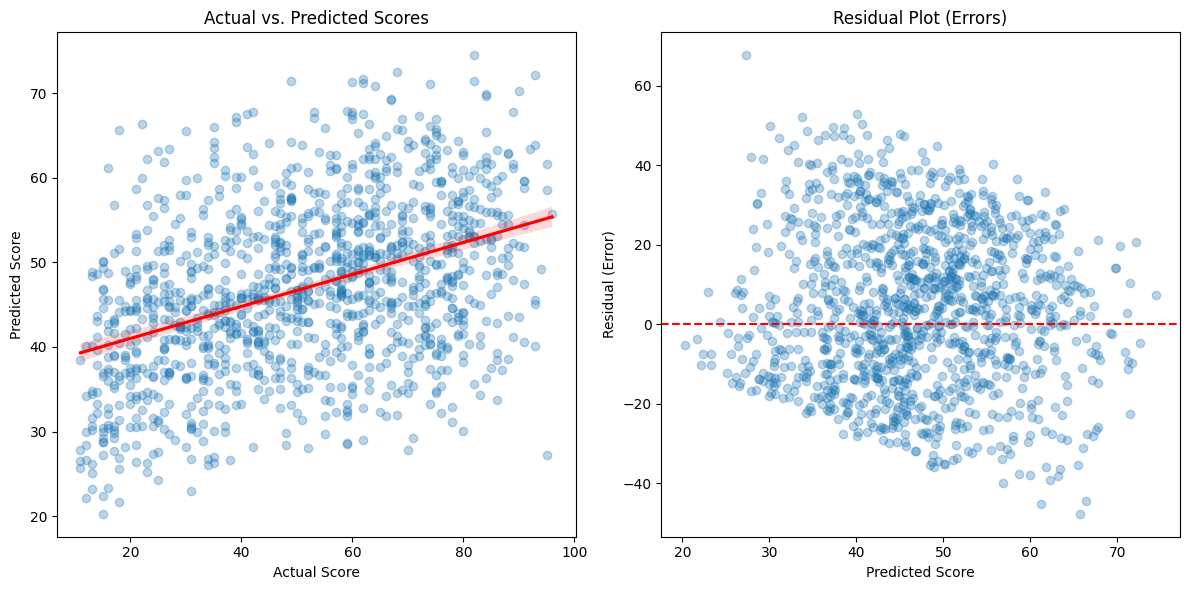

In [ ]:
#gradient boosting
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=1000)
Xtr, Xte = X_train_reg, X_test_reg
ytr, yte = y_train_reg, y_test_reg
Xtr_selected = selector.fit_transform(Xtr, ytr)
Xte_selected = selector.transform(Xte)
ytr_log = np.log1p(y_train_reg.astype(float))
yte_log = np.log1p(y_test_reg.astype(float))
dtrain = lgb.Dataset(Xtr_selected, label=ytr_log)
dtest = lgb.Dataset(Xte_selected, label=yte_log, reference=dtrain)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.015,       
    'num_leaves': 25,             
    'max_depth': 7,               
    'min_data_in_leaf': 50,       
    'feature_fraction': 0.7,     
    'lambda_l1': 3.0,            
    'lambda_l2': 2.0,             
    'seed': 7,
    'verbosity': -1
}
bst = lgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dtest],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=3000),
        lgb.log_evaluation(period=200)
    ]
)
y_pred_log = bst.predict(Xte_selected, num_iteration=bst.best_iteration)
y_pred_final = np.expm1(y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_final))
mae = mean_absolute_error(y_test_reg, y_pred_final)
r2 = r2_score(y_test_reg, y_pred_final)

print(f"\n" + "="*30)
print(f"PERFORMANCE METRICS")
print(f"="*30)
print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAE:  {mae:.4f}")
print(f"Final R2:   {r2:.4f}")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.regplot(x=y_test_reg, y=y_pred_final, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Actual vs. Predicted Scores')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.subplot(1, 2, 2)
residuals = y_test_reg - y_pred_final
plt.scatter(y_pred_final, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (Errors)')
plt.xlabel('Predicted Score')
plt.ylabel('Residual (Error)')
plt.tight_layout()
plt.show()

[I 2026-01-07 14:12:28,488] A new study created in memory with name: no-name-3a29cfda-fed7-4e2e-821b-b11fe5e91311
/Users/umarfaruque/ML1/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/umarfaruque/ML1/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/umarfaruque/ML1/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/umarfaruque/ML1/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/umarfaruque/ML1/venv/lib/python3.13/site-packages/sklea


[INFO] Best parameters saved to best_params.json


/Users/umarfaruque/ML1/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



 Final metrics: 
  Metric   Value
R2 Score  0.1641
    RMSE 19.6646
     MAE 16.3369


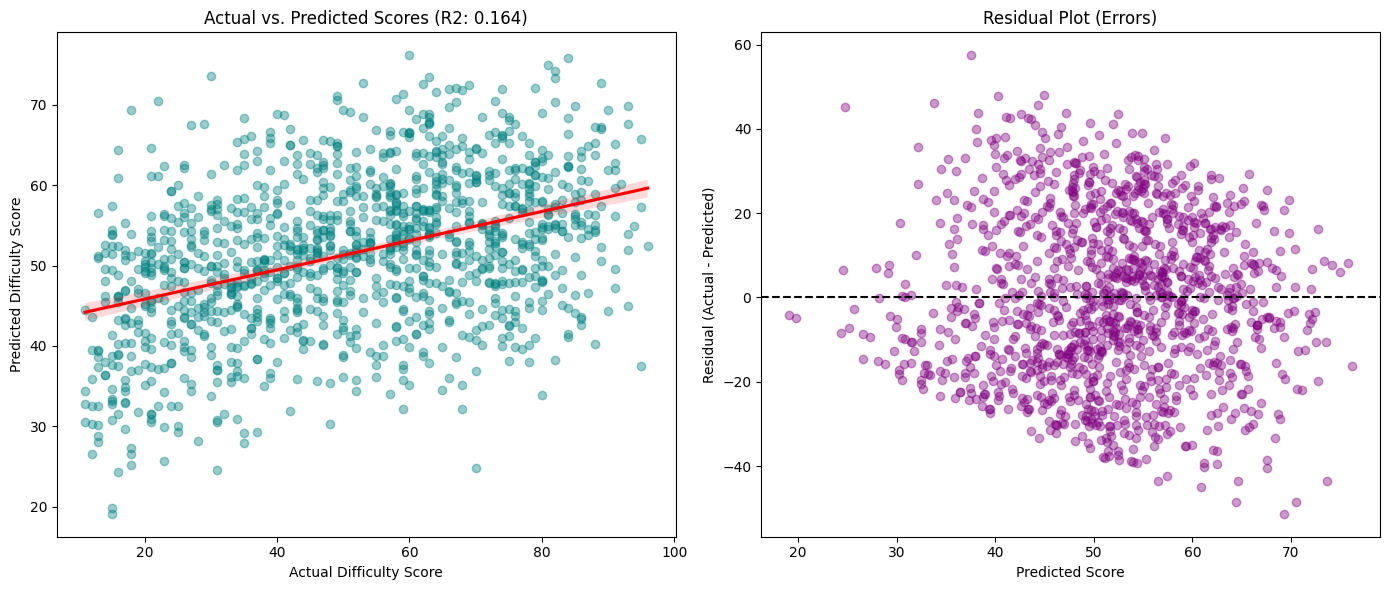

In [ ]:
#gradient boosting with optuna hyperparam tuning
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
Xtr_np = Xtr.toarray() if hasattr(Xtr, "toarray") else Xtr
Xte_np = Xte.toarray() if hasattr(Xte, "toarray") else Xte
selector = SelectKBest(score_func=f_regression, k=800)
Xtr_sel = selector.fit_transform(Xtr_np, ytr)
Xte_sel = selector.transform(Xte_np)
manual_cols = ['hard_topic_count', 'math_density', 'text_len', 'high_difficulty_signal_count','is_short_statement','has_high_constraints','medium_signal_count'] 
X_manual_tr = df.loc[y_train_reg.index, manual_cols].values
X_manual_te = df.loc[y_test_reg.index, manual_cols].values

X_final_tr = np.hstack([Xtr_sel, X_manual_tr])
X_final_te = np.hstack([Xte_sel, X_manual_te])
def objective(trial):
    params = {
        'objective': 'regression',
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 5.0),
        'verbosity': -1,
        'random_state': 7
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_final_tr, ytr, cv=5, scoring='r2').mean()
    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_params = study.best_params
with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)
print("\n[INFO] Best parameters saved to best_params.json")
best_regmodel = lgb.LGBMRegressor(**best_params)
best_regmodel.fit(X_final_tr, ytr)
y_final_preds = best_regmodel.predict(X_final_te)
r2 = r2_score(yte, y_final_preds)
rmse = np.sqrt(mean_squared_error(yte, y_final_preds))
mae = mean_absolute_error(yte, y_final_preds)
metrics_df = pd.DataFrame({
    'Metric': ['R2 Score', 'RMSE', 'MAE'],
    'Value': [f"{r2:.4f}", f"{rmse:.4f}", f"{mae:.4f}"]
})
print("\n" + "="*25)
print(" Final metrics: ")
print("="*25)
print(metrics_df.to_string(index=False))
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.regplot(x=yte, y=y_final_preds, scatter_kws={'alpha':0.4, 'color':'teal'}, line_kws={'color':'red'})
plt.title(f'Actual vs. Predicted Scores (R2: {r2:.3f})')
plt.xlabel('Actual Difficulty Score')
plt.ylabel('Predicted Difficulty Score')
plt.subplot(1, 2, 2)
residuals = yte - y_final_preds
plt.scatter(y_final_preds, residuals, alpha=0.4, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot (Errors)')
plt.xlabel('Predicted Score')
plt.ylabel('Residual (Actual - Predicted)')

plt.tight_layout()
plt.show()

In [21]:
import joblib
import os

if not os.path.exists('modelReg'):
    os.makedirs('modelReg')
joblib.dump(best_regmodel, 'modelReg/modelreg.pkl')
joblib.dump(selector, 'modelReg/selector.pkl')
joblib.dump(manual_cols, 'modelReg/manual_cols.pkl')

print("Models saved in modelReg/ folder.")

Models saved in modelReg/ folder.


In [22]:
import json

signals = {
    "hard_keywords": [word for word, prob in hardvec[:30]],
    "medium_keywords": [word for word, prob in mediumvec[:30]]
}

with open('models/keywords.json', 'w') as f:
    json.dump(signals, f)

In [23]:
import joblib
joblib.dump((Xtr, Xte, ytr, yte, df), 'training_data.pkl')

print("Data saved! Now open your new blank notebook.")

Data saved! Now open your new blank notebook.
